In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import copy
from PIL import Image, ImageChops
import glob
from ast import literal_eval

/home/cdger/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Marking keypoints (test) 

# # Loading the image
# img = cv2.imread('map1.jpg')
 
#  # Converting image to grayscale
# gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
 
# # Applying SIFT detector
# sift = cv2.SIFT_create()
# kp, des = sift.detectAndCompute(gray,None)

 
# # Marking the keypoint on the image using circles
# img=cv2.drawKeypoints(gray ,
#                       kp ,
#                       img ,
#                       flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
# cv2.imwrite('map1-with-keypoints.jpg', img)

In [3]:
#  read the images by taking their path
images = list()

setname = "a_0"
PROJECT_DIR = "/mnt/d/manas-taskphase/mapthemap/"
INPUT_DIR = os.path.join(PROJECT_DIR, f"test_set/test_s_imgs/{setname}")
STITCH_DIR = os.path.join(PROJECT_DIR, f"result/stitched")
PREDICTION_DIR = os.path.join(PROJECT_DIR, f"result/pred")
PATH_DIR = os.path.join(PROJECT_DIR, f"result/path")

dirs = [STITCH_DIR, PREDICTION_DIR, PATH_DIR]

for dir in dirs:
    if not os.path.exists(dir):
        os.makedirs(dir)

# FIND_ROUTE = True # Only implemented for affine mode

modes = ["affine", "perspective"]
MODE =  modes[0]

with open(os.path.join(INPUT_DIR, "clicked_points.txt")) as f:
    if not f.read(1):
        # File is empty
        FIND_ROUTE = False
    else:
        FIND_ROUTE = True
        values = list()
        for line in f:
            name, value = line.split(":", 1)
            values.append(value)
        # print(values)
        for i in range(0, len(values)):
            values[i] = values[i][1:-1]
        # print(values)
        START_IMG_NAME = values[1]
        START_POINT = literal_eval(values[0])
        END_IMG_NAME = values[3]
        END_POINT = literal_eval(values[2])
        print(START_IMG_NAME, START_POINT, END_IMG_NAME, END_POINT)
        track_points = [START_POINT, END_POINT]


# if FIND_ROUTE is True:
#     START_IMG_NAME = "11278735_15_0.png"
#     START_POINT = (10,200) #First cell is on top left, 1st coord is horiz, 2nd coord is vert

#     END_IMG_NAME = "11278735_15_0.png"
#     END_POINT = (380,480)



MIN_MATCH_COUNT = 15 # For BFM

In [4]:
# #  read the images by taking their path
# images = list()

# PROJECT_DIR = "/mnt/d/manas-taskphase/mapthemap/"
# INPUT_DIR = os.path.join(PROJECT_DIR, "mytests/image_fragments")
# STITCH_DIR = os.path.join(PROJECT_DIR, "stitched")
# PREDICTION_DIR = os.path.join(PROJECT_DIR, "preds")

# FIND_ROUTE = True # Only implemented for affine mode

# modes = ["affine", "perspective"]
# MODE =  modes[0]


# if FIND_ROUTE is True:
#     START_IMG_NAME = "11278735_15_0.png"
#     START_POINT = (10,200) #First cell is on top left, 1st coord is horiz, 2nd coord is vert

#     END_IMG_NAME = "11278735_15_0.png"
#     END_POINT = (380,480)

#     track_points = [START_POINT, END_POINT]


# MIN_MATCH_COUNT = 20 # For BFM

In [5]:
files = os.listdir(INPUT_DIR)
print(INPUT_DIR)
print(files)

files = [file for file in files if file[-4:]==".jpg"]

for i in range(0, len(files)):
    # print(files[i][-4:])
    # if files[i][-4:] == ".jpg":
    image = cv2.imread(os.path.join(INPUT_DIR, files[i]))
    print(image)
    images.append(image)

/mnt/d/manas-taskphase/mapthemap/test_set/test_s_imgs/a_0
['clicked_points.txt', 'roi_1.jpg', 'roi_20.jpg', 'roi_22.jpg', 'roi_29.jpg', 'roi_34.jpg', 'roi_36.jpg', 'roi_50.jpg', 'roi_54.jpg', 'roi_56.jpg', 'roi_6.jpg', 'roi_66.jpg', 'roi_69.jpg']
[[[46 52 35]
  [46 52 35]
  [48 51 35]
  ...
  [46 53 48]
  [34 41 36]
  [14 21 18]]

 [[47 53 36]
  [46 52 35]
  [48 51 35]
  ...
  [52 62 56]
  [54 61 56]
  [37 44 39]]

 [[48 52 33]
  [47 51 32]
  [46 50 31]
  ...
  [47 60 52]
  [56 67 59]
  [47 58 50]]

 ...

 [[59 69 69]
  [58 70 70]
  [65 77 77]
  ...
  [46 49 27]
  [46 49 27]
  [46 49 27]]

 [[32 42 42]
  [40 50 50]
  [56 68 68]
  ...
  [46 49 27]
  [46 49 27]
  [46 49 27]]

 [[18 27 30]
  [26 35 38]
  [47 59 61]
  ...
  [46 49 27]
  [46 49 27]
  [46 49 27]]]
[[[  0   0   5]
  [  0   0   4]
  [  0   0   3]
  ...
  [ 44  46  26]
  [ 44  47  25]
  [ 44  47  25]]

 [[  0   0   5]
  [  0   0   3]
  [  0   1   2]
  ...
  [ 44  46  26]
  [ 46  49  27]
  [ 46  49  27]]

 [[  0   0   3]
  [  2 

In [6]:
sift = cv2.SIFT_create()
kp = list()
des = list()

emptyindexes = list()

for i in range(0, len(images)):
    # find the keypoints and descriptors with SIFT
    thiskp, thisdes = sift.detectAndCompute(images[i], None)
    if thisdes is None:
        emptyindexes.append(i)
    kp.append(thiskp)
    des.append(thisdes)


for index in sorted(emptyindexes, reverse=True):
    del images[index]
    del kp[index]
    del des[index]
    del files[index]


if FIND_ROUTE is True:
    for i in range(0, len(files)):
        if files[i] == START_IMG_NAME:
            start_img_index = i
        if files[i] == END_IMG_NAME:
            end_img_index = i

    point_img_index = [start_img_index, end_img_index]
    print(point_img_index)
    print(files[start_img_index], files[end_img_index])

# BFMatcher with default params
bf = cv2.BFMatcher()

In [7]:
class DynamicConnectivity:
    def __init__(self, n):
        self.parent = [i for i in range(n)]
        self.size = [1 for _ in range(n)]

    def find(self, p):
        while p != self.parent[p]:
            self.parent[p] = self.parent[self.parent[p]]
            p = self.parent[p]
        return p

    def union(self, p, q):
        rootP = self.find(p)
        rootQ = self.find(q)
        if rootP == rootQ:
            return

        if self.size[rootP] < self.size[rootQ]:
            self.parent[rootP] = rootQ
            self.size[rootQ] += self.size[rootP]
        else:
            self.parent[rootQ] = rootP
            self.size[rootP] += self.size[rootQ]

    def connected(self, p, q):
        return self.find(p) == self.find(q)

    def get_connected_components(self):
        component_map = {}
        
        for i in range(len(images)):
            root = self.find(i)
            if root not in component_map:
                component_map[root] = list()
                component_map[root].append(i)
            else:
                component_map[root].append(i)
        components = list(component_map.values())
        return components
    
connections = DynamicConnectivity(len(images))

0->1, Not enough matches are found - 0/15
0->2, Not enough matches are found - 0/15
0->4, Not enough matches are found - 0/15
0->5, Not enough matches are found - 0/15
0->6, Not enough matches are found - 0/15
0->9, Not enough matches are found - 0/15
0->10, Not enough matches are found - 0/15
1->0, Not enough matches are found - 0/15
1->2, Not enough matches are found - 0/15
1->3, Not enough matches are found - 1/15
1->4, Not enough matches are found - 0/15
1->5, Not enough matches are found - 0/15
1->6, Not enough matches are found - 0/15
1->7, Not enough matches are found - 0/15
1->8, Not enough matches are found - 0/15
1->10, Not enough matches are found - 0/15
2->0, Not enough matches are found - 2/15
2->1, Not enough matches are found - 2/15
2->3, Not enough matches are found - 4/15
2->4, Not enough matches are found - 0/15
2->7, Not enough matches are found - 1/15
2->8, Not enough matches are found - 3/15
2->9, Not enough matches are found - 0/15
3->1, Not enough matches are fou

<Figure size 640x480 with 0 Axes>

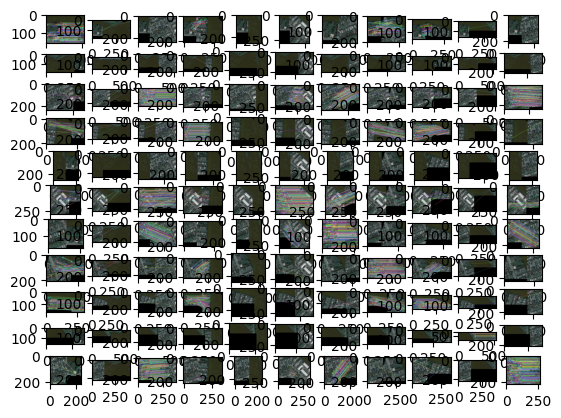

[[0, 3, 7, 8], [2, 5, 6, 10], [1, 9], [4]]


In [8]:
# Determining which image is connected with which image
matchedimages = list()

plt.figure()

f, axarr = plt.subplots(len(images), len(images))

for i in range(0, len(images)):
    # cv.drawMatchesKnn expects list of lists as matches.
    matchedimages.append(list())
    for j in range(0, len(images)):
        matches = bf.knnMatch(des[i],des[j],k=2)
        # Apply ratio test
        good = list()
        for match in matches:
            if len(match)>1:
                if match[0].distance < 0.75*match[1].distance:
                    good.append([match[0]])
                
        matchedimage = cv2.drawMatchesKnn(images[i],kp[i],images[j],kp[j],good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        matchedimages[i].append(matchedimage)
        axarr[i][j].imshow(matchedimages[i][j])
        good = []
        for x in matches:
            if len(x) > 1:
                if x[0].distance < 0.7*x[1].distance:
                    good.append(x[0])
        if len(good)>MIN_MATCH_COUNT:
            connections.union(i, j)
        else:
            print( "{}->{}, Not enough matches are found - {}/{}".format(i,j,len(good), MIN_MATCH_COUNT) )

plt.show()

collections = connections.get_connected_components()
collections = sorted(collections, key=len, reverse=True)
print(collections)

In [9]:
# Set images[0] as reference_image
# Iterate through matches of images in reference_image i.e. matchedimages[0][i]
# Select first match that gives minimum number of good matches
# Blend images to form new reference_image
# Continue terate through matches of images[] not including already blended images

# Create all possible blend groups
# Stitch each blend group
# Create connectivity grid

In [10]:
def pltimg(img):
    #converting to rgb and [0,1] for matplotlib display
    img = np.array(img,dtype=float)/float(255)
    if len(img.shape) ==3:
        img = img[:,:,::-1]
    else:
        img = img[:,:]
    return img


def seamless_merge(image1, image2):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Find non-zero regions in both images
    _, mask1 = cv2.threshold(gray1, 10, 255, cv2.THRESH_BINARY)
    _, mask2 = cv2.threshold(gray2, 10, 255, cv2.THRESH_BINARY)

    # Invert the masks
    # mask1_inv = cv2.bitwise_not(mask1)
    # mask2_inv = cv2.bitwise_not(mask2)

    # Combine the inverted masks to get the region of overlap
    overlap_mask = cv2.bitwise_and(mask1, mask2)
    # overlap_mask = cv2.bitwise_not(overlap_mask)
    image2_non_overlap = np.copy(image2)
    image1_non_overlap = np.copy(image1)
    image2_non_overlap[overlap_mask==255] = 0.6*image2[overlap_mask==255]
    image1_non_overlap[overlap_mask==255] = 0.4*image1[overlap_mask==255]

    # plt.imshow(overlap_mask)
    # plt.show()
    # Perform seamless cloning only in the non-overlapping regions
    height, width, _ = image1.shape
    center = (width // 2, height // 2)
    # merged_image = cv2.seamlessClone(image2_non_overlap, image1_non_overlap, np.zeros(image2.shape[0:2]).fill(255), center, cv2.MIXED_CLONE)
    merged_image = image1_non_overlap + image2_non_overlap
    # merged_image = cv2.seamlessClone(image2_overlap, merged_image, np.zeros(image2.shape[0:2]).fill(255), center, cv2.MIXED_CLONE, 1)

    return merged_image


def selective_color_blur(image, target_color, color_threshold, kernel_size):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Threshold the grayscale image to select black pixels
    _, mask = cv2.threshold(gray_image, 20, 255, cv2.THRESH_BINARY)
    mask = cv2.bitwise_not(mask)
    # Apply blur only to pixels of the specified color
    blurred_image = np.copy(image)
    # blurred_image[mask == 255] = cv2.medianBlur(blurred_image, (kernel_size, kernel_size), 0)[mask == 255]
    blurred_image[mask == 255] = cv2.medianBlur(blurred_image, kernel_size)[mask == 255]
    return blurred_image


# create new image of desired size and color for padding
def getpaddedimg(new_image_height, new_image_width, old_image_width, old_image_height, img, channels = 3):
    color = (0,0,0)
    if channels == 1:
        result = np.full((new_image_height,new_image_width), color[0:1], dtype=np.uint8)
    else:
        result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2

    # copy img image into center of result image
    result[y_center:y_center+old_image_height, 
        x_center:x_center+old_image_width] = img
    return result


# def crop_image(img, pixel_value=0):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     crop_rows = np.copy(img)[~np.all(gray == pixel_value, axis=1), :, :]
#     cropped_image = crop_rows[:, ~np.all(crop_rows == pixel_value, axis=0)]
#     return cropped_image


def crop_image(im):
    im = Image.fromarray(im)
    bg = Image.new(im.mode, im.size, (0,0,0))
    # bg = Image.new(im.mode, im.size, (255,255,255))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    result = im
    if bbox:
        result = im.crop(bbox)
    return np.array(result)


# def get_black_pixels_before_color(image, direction='rows'):
#     """
#     Get the number of rows or columns of black pixels before any color appears.
    
#     Args:
#         image (numpy.ndarray): Input image.
#         direction (str): Direction to compute ('rows' or 'columns').

#     Returns:
#         int: Number of rows or columns of black pixels before any color appears.
#     """
#     # Convert image to grayscale
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # Threshold image to obtain binary image
#     _, binary_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)

#     # Compute sum of pixel values along rows or columns
#     if direction == 'rows':
#         sums = np.sum(binary_image, axis=1)
#     elif direction == 'columns':
#         sums = np.sum(binary_image, axis=0)
#     else:
#         raise ValueError("Direction must be 'rows' or 'columns'.")

#     # Find the index of the first non-zero element
#     for i in range(0, len(sums)):
#         if sums[i] != 0:
#             return i

#     # Return the number of rows or columns before the first non-zero element
#     # return first_nonzero_index

In [11]:
stitch_order = list()
image_warps = list()


unblended_collections = copy.deepcopy(collections)
blended_collections = list()

i = 0
for unblended_image_group in unblended_collections:
    unblended_image_indexes = copy.deepcopy(unblended_image_group)
    ref = unblended_image_indexes[0]
    reference_image = images[ref]
    unblended_image_indexes.remove(ref)

    stitch_order.append(list())
    image_warps.append(list())
    stitch_order[i].append(ref)
    image_warps[i].append(reference_image)
    
    key_points_broken = False
    
    while len(unblended_image_indexes)!=0:
        print(unblended_image_indexes)
        matched_once = False
        for k in unblended_image_indexes:
            new_image_width = reference_image.shape[1] + (2*images[k].shape[1])
            new_image_height = reference_image.shape[0] + (2*images[k].shape[0])
            reference_image = getpaddedimg(new_image_height, new_image_width, reference_image.shape[1], reference_image.shape[0], reference_image)
            current_image = getpaddedimg(new_image_height, new_image_width, images[k].shape[1], images[k].shape[0], images[k])

            thiskp, thisdes = sift.detectAndCompute(current_image, None)
            refkp, refdes = sift.detectAndCompute(reference_image, None)

            if refdes is None:
                print(f"{i} {k} Key points not found in ref. Moving to next blend.")
                unblended_collections.append(unblended_image_indexes[k:])
                key_points_broken = True
                break
                
            
            
            # print(thisdes.dtype, refdes.dtype)
            matches = bf.knnMatch(thisdes,refdes,k=2)
            good = list()
            for match in matches:
                if match[0].distance < 0.75*match[1].distance:
                    good.append([match[0]])
            matchedimage = cv2.drawMatchesKnn(current_image, thiskp, reference_image,refkp,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

            # axarr[i][j].imshow(matchedimages[i][j])
            # for m,n in matches:
            #     if m.distance < 0.75*n.distance:
            #         good.append([m])
            good = []
            for m,n in matches:
                if m.distance < 0.7*n.distance:
                    good.append(m)
            if len(good)>=MIN_MATCH_COUNT:
                matched_once = True
                src_pts = np.float32([thiskp[m.queryIdx].pt for m in good]).reshape(-1,1,2)
                dst_pts = np.float32([refkp[m.trainIdx].pt for m in good]).reshape(-1,1,2)
                # print(src_pts)
                # print(dst_pts)
                if MODE == "affine":
                    M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)
                    warped_image = cv2.warpAffine(current_image, M, (reference_image.shape[1], reference_image.shape[0]))
                    # if FIND_ROUTE is True:
                    #     for tpi in range(0, len(track_points)):
                    #         # Take into account padding and transform
                    #         if k == point_img_index[tpi]:
                    #             # Going to be blended
                    #             homogenous_coords = np.array([track_points[tpi][0]+((new_image_height-images[k].shape[0])/2), track_points[tpi][1]+((new_image_width-images[k].shape[1])/2), 1])
                    #         # if (point_img_index[tpi] in unblended_image_group and point_img_index[tpi] not in unblended_image_indexes):
                    #         #     # Already blended
                    #         #     homogenous_coords = np.array([track_points[tpi][0]+((new_image_height-reference_image.shape[0])/2), track_points[tpi][1]+((new_image_width-reference_image.shape[1])/2), 1])
                    #         if k == point_img_index[tpi]:
                    #             track_points[tpi] = np.matmul(M, homogenous_coords)
                    #             print("tp",track_points)
                elif MODE == "perspective":
                    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
                    warped_image = cv2.warpPerspective(current_image, M, (reference_image.shape[1], reference_image.shape[0]))

                stitch_order[i].append(k)
                image_warps[i].append(warped_image) # This image warp will be used for prediction
                # alpha = 1.0
                # beta = 1.0
                # reference_image = cv2.addWeighted(stitched_image, alpha, reference_image, beta, 0.0)
                # reference_image = cv2.bitwise_or(reference_image, warped_image)
                # reference_image = cv2.seamlessClone(warped_image, reference_image, np.zeros(reference_image.shape), (0,0), cv2.MIXED_CLONE)
                reference_image = seamless_merge(warped_image, reference_image)
                # reference_image = cv2.seamlessClone(warped_image, reference_image, mask, (reference_image.shape[0]//2, reference_image.shape[1]//2), cv2.MIXED_CLONE)
                # reference_image = alpha_blend_with_mask(reference_image, warped_image, 1)

                # cv2.imshow(f"stitch {k}",reference_image)
                # while True:
                #     key = cv2.waitKey(0) & 0xFF
                #     print(k)
                #     if key == ord('c'): # you can put any key here
                #         cv2.destroyAllWindows()
                #         break
                
                unblended_image_indexes.remove(k) 
            else:
                print( "{}->ref, Not enough matches are found - {}/{}".format(k,len(good), MIN_MATCH_COUNT) )

            # if FIND_ROUTE is True:
            #     for tpi in range(0, len(track_points)):
            #         if k == point_img_index[tpi] or (point_img_index[tpi] in unblended_image_group and point_img_index[tpi] not in unblended_image_indexes):
            #             # Take into account cropping
            #             print(track_points)
            #             print(get_black_pixels_before_color(reference_image))
            #             track_points[tpi] = np.subtract(np.array(track_points[tpi]),np.array([get_black_pixels_before_color(reference_image,"rows"), get_black_pixels_before_color(reference_image,"columns")]))
            #             print("tp",track_points)

            reference_image = crop_image(reference_image) # Removing padding
            
        if matched_once == False:
            # reference_image = crop_image(reference_image)
            break

        if key_points_broken == True:
            break


    # reference_image = cv2.medianBlur(reference_image, 3)     # Removing pepper noise developed during bitwise OR
    blended_collections.append(reference_image)
    i = i+1


[3, 7, 8]
[7]
[5, 6, 10]
[6]
[9]
9->ref, Not enough matches are found - 10/15


In [12]:
print("Number of blends formed:", len(blended_collections))

delfiles = glob.glob(f'{STITCH_DIR}/*')
for f in delfiles:
    os.remove(f)

i = 0

for i in range(0, len(blended_collections)):
    blended_collections[i] = selective_color_blur(blended_collections[i], (0,0,0), 30, 17)
#     blended_collections[i] = cv2.medianBlur(blended_collections[i], 5)     # Removing pepper noise developed during bitwise OR



for blend in blended_collections:
    stitchpath = os.path.join(STITCH_DIR,f"stitched{i}.jpg")
    print(stitchpath)
    cv2.imwrite(stitchpath, blend)
    # cv2.imwrite(stitchpath, selective_color_blur(blend, (0,0,0), 20, 9))
    i = i + 1
    # while True:
    #     key = cv2.waitKey(0) & 0xFF
    #     print(k)
    #     if key == ord('c'): # you can put any key here
    #         cv2.destroyAllWindows()
    #         break

Number of blends formed: 4
/mnt/d/manas-taskphase/mapthemap/result/stitched/stitched3.jpg
/mnt/d/manas-taskphase/mapthemap/result/stitched/stitched4.jpg
/mnt/d/manas-taskphase/mapthemap/result/stitched/stitched5.jpg
/mnt/d/manas-taskphase/mapthemap/result/stitched/stitched6.jpg


In [13]:
if FIND_ROUTE is True:
    points_connected = False

    # Showing start point in start image
    tracked_start = cv2.circle(images[start_img_index], START_POINT, 30, (255,0,0), 20)
    plt.imshow(tracked_start)
    plt.show()

    # Showing end point in end image
    tracked_end = cv2.circle(images[end_img_index], END_POINT, 30, (0,255,0), 20)
    plt.imshow(tracked_end)
    plt.show()


    # Showing start and end points in blend
    points_connected = connections.connected(start_img_index, end_img_index)
    if points_connected:    
        for i in range(0, len(unblended_collections)):
            if start_img_index in unblended_collections[i] and end_img_index in unblended_collections[i]:
                desired_blend_index = i
                desired_blend = np.copy(blended_collections[i])
                for j in range (0, len(point_img_index)):
                    index = point_img_index[j]
                    thiskp, thisdes = sift.detectAndCompute(images[index], None)
                    refkp, refdes = sift.detectAndCompute(desired_blend, None)
                    matches = bf.knnMatch(thisdes,refdes,k=2)
                    good = []
                    for m,n in matches:
                        if m.distance < 0.7*n.distance:
                            good.append(m)
                    src_pts = np.float32([thiskp[m.queryIdx].pt for m in good]).reshape(-1,1,2)
                    dst_pts = np.float32([refkp[m.trainIdx].pt for m in good]).reshape(-1,1,2)
                    M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)
                    homogenous_coords = np.array([track_points[j][0], track_points[j][1], 1])
                    track_points[j] = np.matmul(M, homogenous_coords)
                for k in range(0, len(track_points)):
                    print(track_points[k])
                    if k == 0:
                        colour = (255,0,0)
                    elif k == 1:
                        colour = (0,255,0)
                    tracked_blend = cv2.circle(desired_blend, tuple(track_points[k].astype(int)), 30, colour, 20)
                plt.imshow(tracked_blend)
                plt.show()
                break   
    else:
        print("Start and end points are not connected")

    # # Showing start and end points in blend
    # for i in range(0, len(unblended_collections)):
    #     if start_img_index in unblended_collections[i] and end_img_index in unblended_collections[i]:
    #         points_connected = True
    #         for track_point in track_points:
    #             print(track_point)
    #             tracked_blend = cv2.circle(blended_collections[i], tuple(track_point.astype(int)), 30, (155,155,155), 20)
    #         plt.imshow(tracked_blend)
    #         plt.show()
    #         break
    # if points_connected is False:
    #     print("Start and end points are not connected")


In [14]:
import tensorflow as tf
from keras.models import load_model
from keras.layers import Flatten
from tensorflow.keras import Model

2024-04-17 12:27:51.318316: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 12:27:51.337447: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 12:27:51.337476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 12:27:51.338030: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-17 12:27:51.341365: I tensorflow/core/platform/cpu_feature_guar

In [15]:
def dice_coef(y_true, y_pred, smooth = 1):
    # Flatten the tensors
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # Calculate intersection and sum of squares
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    sum_of_squares = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    # Calculate Dice coefficient
    dice = (2. * intersection + smooth) / (sum_of_squares + smooth)

    return dice

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [23]:
# Model 1 - Trained (Aerial UNet Seg3)
# savedmodel=load_model("/mnt/d/models/RouteGenerator.h5")
# size = 128

#Model 2 - BEST SO FAR (Skeyenet)
savedmodel=load_model("/mnt/d/models/skeyenet/Models/road_mapper_final.h5", custom_objects={"dice_coef": dice_coef, "dice_loss": soft_dice_loss, "dice_coef_loss": soft_dice_loss})
size = 256

#Model 3
# savedmodel = load_model("/mnt/d/models/road-extraction/models/roads_extraction.h5")
# size = 256

# Model 4 - Trained (Aerial UNet Seg4)
# savedmodel = load_model("/mnt/d/models/unet-massachussetts.h5", custom_objects={"dice_coef_loss": soft_dice_loss, "dice_coef": dice_coef})
# size = 1024


o = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid', name="output")(savedmodel.layers[-1].output)
model = Model(inputs=savedmodel.input, outputs=[o])


In [24]:
from skimage.util import view_as_blocks

def pad_image(image, target_size):
    """
    Pad an image array until its dimensions are divisible by a certain size.

    Parameters:
        image (numpy.ndarray): Input image array.
        target_size (int): Size to which the dimensions should be divisible.

    Returns:
        numpy.ndarray: Padded image array.
    """
    # Calculate the amount of padding needed for each dimension
    pad_height = (target_size[0] - image.shape[0] % target_size[0]) % target_size[0]
    pad_width = (target_size[1] - image.shape[1] % target_size[1]) % target_size[1]

    # Pad the image array
    padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0,0)), mode='constant')

    return padded_image


def array_to_patches(array, patch_size):
    """
    Convert a numpy array into a matrix of image patches.

    Parameters:
        array (numpy.ndarray): Input numpy array.
        patch_size (tuple): Size of each patch in the form (patch_height, patch_width).

    Returns:
        numpy.ndarray: Matrix of image patches.
    """

    padded_array = pad_image(array, patch_size)
    array = None
    array = padded_array

    # Get the shape of the input array
    array_height, array_width, array_channels = array.shape

    # Calculate the number of patches along each axis
    num_patches_height = array_height // patch_size[0]
    num_patches_width = array_width // patch_size[1]

    # Reshape the array into a matrix of patches
    patches = view_as_blocks(array, block_shape=(patch_size[0], patch_size[1], patch_size[2]))

    # Flatten the patches matrix to get a 2D matrix of patches
    patches = patches.reshape(num_patches_height * num_patches_width, patch_size[0], patch_size[1], patch_size[2])

    return patches, num_patches_height, num_patches_width


def merge_patches_to_image(patches, image_shape):
    """
    Merge a matrix of image patches back into a single image. (2D)

    Parameters:
        patches (numpy.ndarray): Matrix of image patches.
        image_shape (tuple): Shape of the original image in the form (image_height, image_width).

    Returns:
        numpy.ndarray: Merged single image.
    """
    # Get the height and width of the original image
    image_height, image_width = image_shape

    # Calculate the number of patches along each axis
    num_patches_height = image_height // patches.shape[1]
    num_patches_width = image_width // patches.shape[2]

    # Reshape the patches matrix into a 3D array
    patches = patches.reshape(num_patches_height, num_patches_width, patches.shape[1], patches.shape[2])

    # Merge patches along the height axis to form rows
    rows = [np.hstack(patches[i]) for i in range(num_patches_height)]

    # Merge rows along the width axis to form the final image
    merged_image = np.vstack(rows)

    return merged_image

(2, 256, 256, 3)
1/1 [==============================] - 0s 99ms/step
(2, 256, 256, 1)
(4, 256, 256, 3)
1/1 [==============================] - 0s 236ms/step
(4, 256, 256, 1)
(1, 256, 256, 3)
1/1 [==============================] - 0s 45ms/step
(1, 256, 256, 1)
(1, 256, 256, 3)
1/1 [==============================] - 0s 49ms/step
(1, 256, 256, 1)


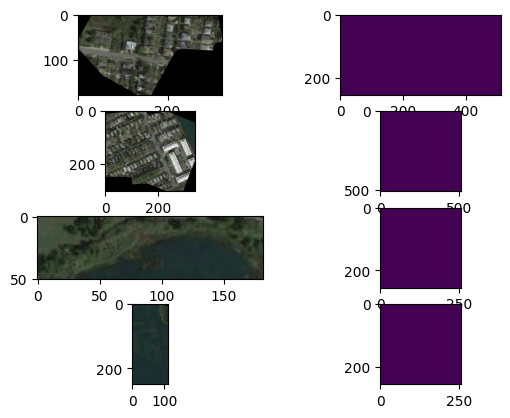

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0

In [37]:
# Preprocess method 1

def get_merged_patched_prediction_from_image(im, patch_size):
    patches, ph, pw = array_to_patches(im, (patch_size,patch_size,3))
    # print(im)
    print(patches.shape)
    # im = cv2.resize(im, (size, size), interpolation = cv2.INTER_AREA)
    # print(im.shape)
    preds = model.predict(patches/255)
    print(preds.shape)

    mergedpred = merge_patches_to_image(preds, (ph*size,pw*size))
    # threshed = mergedpred
    ret, threshed = cv2.threshold(mergedpred*255, 127.5, 255, cv2.THRESH_BINARY) 
    return threshed

# from skimage import transform

preds = list()
for blend in blended_collections:
    pred = get_merged_patched_prediction_from_image(blend, size)
    # pred = transform.resize(pred, (256, 256, 3))
    # pred = cv2.bitwise_not(cv2.dilate(cv2.bitwise_not(pred),(10,10)))
    preds.append(pred)

if len(blended_collections) == 1:
    f, axarr = plt.subplots(2)
    axarr[0].imshow(pltimg(blended_collections[0]))
    axarr[1].imshow(preds[0].astype('uint8'))    
else:
    f, axarr = plt.subplots(len(blended_collections), 2)
    for i in range(0, len(blended_collections)):
        axarr[i,0].imshow(pltimg(blended_collections[i]))
        axarr[i,1].imshow(preds[i].astype('uint8'), vmin = 0, vmax = 1)

plt.show()

print(preds)


1/1 [==============================] - 0s 45ms/step


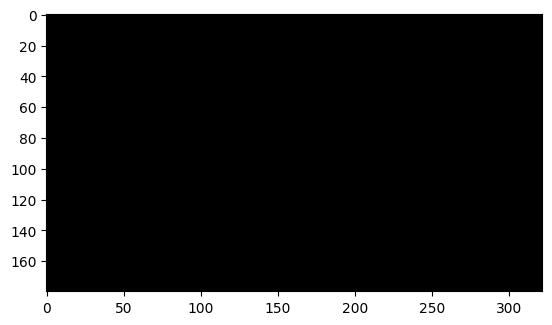

1/1 [==============================] - 0s 89ms/step


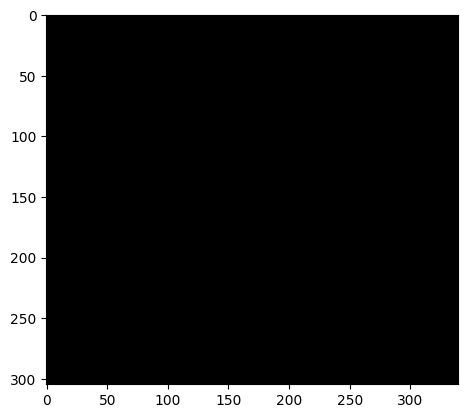

1/1 [==============================] - 0s 43ms/step


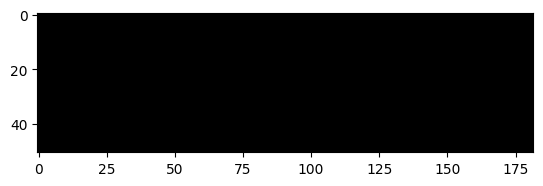

1/1 [==============================] - 0s 46ms/step


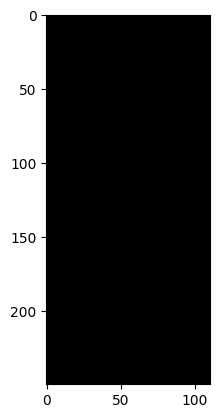

[<PIL.Image.Image image mode=L size=322x180 at 0x772601455180>, <PIL.Image.Image image mode=L size=340x305 at 0x772600B5BEE0>, <PIL.Image.Image image mode=L size=182x51 at 0x7725558F1840>, <PIL.Image.Image image mode=L size=111x250 at 0x772600B58820>]


In [39]:
# Preprocess method 2

# Imports 
import numpy as np

from tensorflow.keras.models import load_model
# from loss_functions import dice_coef as dice_coef_loss, iou_coef, soft_dice_loss
from tensorflow.keras.preprocessing.image import load_img
from skimage import transform
from PIL import Image

# Global Variables
IMG_HEIGHT, IMG_WIDTH, CHANNELS = size, size, 3
ORIG_HEIGHT, ORIG_WIDTH = 0, 0

# Gives a tensor of size (1, IMG_HEIGHT, IMG_WIDTH, CHANNELS)
def image_makeup(np_img):
    # np_img = load_img(img_filepath)
    # np_img = np_img/255
    global ORIG_HEIGHT, ORIG_WIDTH
    ORIG_HEIGHT, ORIG_WIDTH = np_img.shape[0], np_img.shape[1]
    np_img = np.array(np_img).astype('float32') 
    np_img = transform.resize(np_img, (size, size, 3))
    np_img = np.expand_dims(np_img, axis=0)
    return np_img

def clean_up_predictions(preds) -> list:
    threshold = 0.5
    preds = 255 * (preds > threshold).astype('uint8')
    imgs = []
    for i in range(len(preds)):
        image = np.squeeze(preds[i][:, :, 0])
        image = Image.fromarray(image)
        image = image.resize((ORIG_WIDTH, ORIG_HEIGHT))
        imgs.append(image)
    return imgs

def predict(img) -> list:
    # model = load_model("./Models/road_mapper_final.h5", custom_objects = {
    #     "soft_dice_loss" : soft_dice_loss,
    #     "iou_coef" : iou_coef,
    #     "dice_coef_loss" : dice_coef_loss,
    #     "dice_loss" : dice_coef_loss,
    # })
    # model=load_model("/mnt/d/models/skeyenet/Models/road_mapper_final.h5", custom_objects={"dice_coef": dice_coef, "dice_loss": soft_dice_loss, "dice_coef_loss": soft_dice_loss})
    preds = model.predict(image_makeup(img))
    imgs_list = clean_up_predictions(preds)
    return imgs_list 


true_predictions = list()
for blend in blended_collections:
    preds = predict(blend)
    for pred in preds:
        true_predictions.append(pred)
        plt.imshow(pred, cmap="gray")
        plt.show()


In [27]:
delfiles = glob.glob(f'{PREDICTION_DIR}/*')
for f in delfiles:
    os.remove(f)

for i in range(0, len(preds)):
    cv2.imwrite(os.path.join(PREDICTION_DIR, f"pred{i}.jpg"), np.float32(true_predictions[i]))
    

4/4 [==============================] - 0s 61ms/step


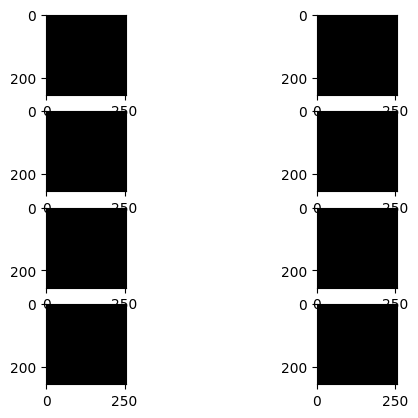

In [28]:
# Preprocess method 3
# Resizing method

ims = list()
imshapes = list()
for imname in os.listdir(STITCH_DIR):
    im = cv2.imread(os.path.join(STITCH_DIR, imname))
    imshapes.append(im.shape)
    im = transform.resize(im, (size, size, 3))
    # im = cv2.resize(im, (size, size), interpolation = cv2.INTER_AREA)
    ims.append(im)
ims = np.array(ims)
predictions = model.predict(ims/255, batch_size = 1)*255

i = 0
threshes = list()
for pred in predictions:
    ret, thresh = cv2.threshold(pred, 0.5, 255, cv2.THRESH_BINARY)
    threshes.append(thresh)
    i = i+1

f, axarr = plt.subplots(len(ims), 2)

if len(ims) == 1:
    axarr[0].imshow(pltimg(ims[0]))
    axarr[1].imshow(pltimg(threshes[0]), cmap="gray")    
else:
    for i in range(0, len(ims)):
        axarr[i,0].imshow(pltimg(ims[i]))
        axarr[i,1].imshow(pltimg(threshes[i]), cmap="gray")
plt.show()

In [29]:
import numpy as np
import heapq

def heuristic(position, goal):
    # Manhattan distance heuristic
    return abs(position[0] - goal[0]) + abs(position[1] - goal[1])

def astar_search(grid, start, goal):
    # Define possible movements: up, down, left, right, diagonals
    moves = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    
    # Define grid dimensions
    rows, cols = grid.shape
    
    # Initialize open list with start position and its cost
    open_list = [(0, start)]
    heapq.heapify(open_list)
    
    # Initialize dictionaries to store costs and parent nodes
    cost_so_far = {start: 0}
    came_from = {}
    
    while open_list:
        # Get the node with the lowest cost from the open list
        current_cost, current_node = heapq.heappop(open_list)
        
        # Check if current node is the goal
        if current_node == goal:
            path = []
            while current_node in came_from:
                path.append(current_node)
                current_node = came_from[current_node]
            path.append(start)
            path.reverse()
            return path
        
        # Explore neighboring nodes
        for move in moves:
            next_node = (current_node[0] + move[0], current_node[1] + move[1])
            
            # Check if next node is within grid boundaries and not an obstacle
            if 0 <= next_node[0] < rows and 0 <= next_node[1] < cols and grid[next_node] != 0:
                new_cost = cost_so_far[current_node] + 1  # Assuming uniform cost for movement
                
                # Check if the new cost is lower than the existing cost or if the node is not visited yet
                if next_node not in cost_so_far or new_cost < cost_so_far[next_node]:
                    cost_so_far[next_node] = new_cost
                    priority = new_cost + heuristic(next_node, goal)
                    heapq.heappush(open_list, (priority, next_node))
                    came_from[next_node] = current_node
    
    # If no path is found
    return None


if FIND_ROUTE is True and points_connected is True:
    start = tuple([int(i) for i in track_points[0]][::-1])
    goal = tuple([int(i) for i in track_points[1]][::-1])
    pred = np.array(true_predictions[desired_blend_index])
    print(start)
    print(goal)
    print(pred.shape)
    path = astar_search(pred, start, goal) # returns list of path node indexes
    print(path)
    predpathmap = np.copy(pred)
    blendpathmap = np.copy(desired_blend)
    if path is None:
        print("No path found")
    else:
        surround = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1), (0,0)]
        for pathnode in path:
            for s in surround:
                predpathmap[pathnode[0]+s[0]][pathnode[1]+s[1]] = 255//2 # Should be dark wrt road which is light in the mask
                blendpathmap[pathnode[0]+s[0]][pathnode[1]+s[1]][:] = (0,0,255)
        plt.imshow(predpathmap, cmap="gray")
        plt.show()
        plt.imshow(blendpathmap)
        plt.show()

    delfiles = glob.glob(f'{PATH_DIR}/*')
    for f in delfiles:
        os.remove(f)
    print(os.path.join(PATH_DIR, "path.jpg"))
    cv2.imwrite(os.path.join(PATH_DIR, "path.jpg"), blendpathmap)
